# Variance Metrics

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

## Functions

In [4]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [5]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [6]:
def get_ds_binned(ds, lon_bins, lat_bins):
    
    ds_binned = xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True)
    
    lon_l = np.arange(lon_bins[0],lon_bins[-1],3)
    lon_r = np.arange(lon_bins[1],lon_bins[-1]+1,3)
    lon_c = (lon_l + lon_r)/2

    lat_l = np.arange(lat_bins[0],lat_bins[-1],3)
    lat_r = np.arange(lat_bins[1],lat_bins[-1]+1,3)
    lat_c = (lat_l + lat_r)/2

    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
    })
    
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])
    
    if isinstance(ds_binned, xr.Dataset):
        # For xarray.Dataset, use rename_dims and rename_vars
        ds_binned = ds_binned.rename_dims({"rho_grid": "density"}).rename_vars({"rho_grid": "density"})
    elif isinstance(ds_binned, xr.DataArray):
        # For xarray.DataArray, use rename to rename the dimension
        ds_binned = ds_binned.rename({"rho_grid": "density"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    
    return ds_binned

## K_rho

In [7]:
diff_rho = xr.open_dataset('/swot/SUM05/amf2288/diff_rho_3.nc')
K_rho = diff_rho.K_rho

In [8]:
K_rho = K_rho.rename({'rho_grid':'density'})

In [14]:
lfilt = 100
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-67.5,68,3)

## Mesoscale Variance

In [9]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [10]:
ct_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_e_3.nc', chunks={'N_PROF':100000})
sa_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_e_3.nc', chunks={'N_PROF':100000})

In [12]:
ct_e_z2 = ct_e.differentiate(coord='PRES_INTERPOLATED')**2
sa_e_z2 = sa_e.differentiate(coord='PRES_INTERPOLATED')**2

In [15]:
%%time
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt)
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt)

CPU times: user 4min 18s, sys: 2min 57s, total: 7min 16s
Wall time: 5min 17s


In [21]:
ct_e_z2_filt.name = 'ct_e_z2_filt'
ct_e_z2_filt = ct_e_z2_filt.to_dataset()

sa_e_z2_filt.name = 'sa_e_z2_filt'
sa_e_z2_filt = sa_e_z2_filt.to_dataset()

In [22]:
%%time
ct_e_z2_filt_rho = get_ds_rho(ct_e_z2_filt, ds.SIG0, rho_grid, variables=['ct_e_z2_filt'])
sa_e_z2_filt_rho = get_ds_rho(sa_e_z2_filt, ds.SIG0, rho_grid, variables=['sa_e_z2_filt'])

Completed comp for ct_e_z2_filt
Completed ct_e_z2_filt
Completed merge
Completed comp for sa_e_z2_filt
Completed sa_e_z2_filt
Completed merge
CPU times: user 18min 12s, sys: 1min 29s, total: 19min 41s
Wall time: 19min 41s


In [23]:
%%time
ct_var2 = get_ds_binned(ct_e_z2_filt_rho, lon_bins, lat_bins)
sa_var2 = get_ds_binned(sa_e_z2_filt_rho, lon_bins, lat_bins)

CPU times: user 7min 15s, sys: 1min 18s, total: 8min 34s
Wall time: 8min 34s


In [24]:
%%time
ct_var2.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_var2.nc')
sa_var2.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa_var2.nc')

CPU times: user 4min 15s, sys: 10min 18s, total: 14min 34s
Wall time: 2min 5s


## Microscale Variance

In [19]:
ct_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_3.nc', chunks={'N_PROF':100000})
sa_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_3.nc', chunks={'N_PROF':100000})

In [25]:
ct_m_z2 = ct_m.differentiate(coord='PRES_INTERPOLATED')**2
sa_m_z2 = sa_m.differentiate(coord='PRES_INTERPOLATED')**2

In [26]:
ct_m_z2.name = 'ct_m_z2'
ct_m_z2 = ct_m_z2.to_dataset()

sa_m_z2.name = 'sa_m_z2'
sa_m_z2 = sa_m_z2.to_dataset()

In [27]:
%%time
ct_m_z2_rho = get_ds_rho(ct_m_z2, ds.SIG0, rho_grid, variables=['ct_m_z2'])
sa_m_z2_rho = get_ds_rho(sa_m_z2, ds.SIG0, rho_grid, variables=['sa_m_z2'])

Completed comp for ct_m_z2
Completed ct_m_z2
Completed merge
Completed comp for sa_m_z2
Completed sa_m_z2
Completed merge
CPU times: user 41.2 s, sys: 21.2 s, total: 1min 2s
Wall time: 1min 2s


In [28]:
%%time
ct_var3 = get_ds_binned(ct_m_z2_rho, lon_bins, lat_bins)
sa_var3 = get_ds_binned(sa_m_z2_rho, lon_bins, lat_bins)

CPU times: user 34.7 ms, sys: 4.31 ms, total: 39 ms
Wall time: 36.6 ms


In [29]:
%%time
ct_var3.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_var3.nc')
sa_var3.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa_var3.nc')

CPU times: user 1h 48min 58s, sys: 1h 11min 39s, total: 3h 37s
Wall time: 1h 23min 50s


## Fractions

In [32]:
ct_meso_VPR  = K_rho*ct_var2
ct_micro_VPR = K_rho*ct_var3

sa_meso_VPR  = K_rho*sa_var2
sa_micro_VPR = K_rho*sa_var3

In [33]:
ct_meso_VPR.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_meso_VPR.nc')
ct_micro_VPR.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_micro_VPR.nc')

sa_meso_VPR.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa_meso_VPR.nc')
sa_micro_VPR.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa_micro_VPR.nc')

In [50]:
%%time
ct_tot   = ct_meso_VPR  + ct_micro_VPR
ct2_frac = ct_meso_VPR  / ct_tot
ct3_frac = ct_micro_VPR / ct_tot

sa_tot   = sa_meso_VPR  + sa_micro_VPR
sa2_frac = sa_meso_VPR  / sa_tot
sa3_frac = sa_micro_VPR / sa_tot

CPU times: user 197 ms, sys: 1.81 s, total: 2.01 s
Wall time: 2 s


In [54]:
ct_tot.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_tot.nc')
sa_tot.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa_tot.nc')

In [55]:
ct2_frac.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct2_frac.nc')
sa2_frac.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa2_frac.nc')

## Plots: CT

In [56]:
ct_meso_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_meso_VPR.nc')
ct_micro_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_micro_VPR.nc')
ct_tot_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_tot.nc')
ct2_frac_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct2_frac.nc')

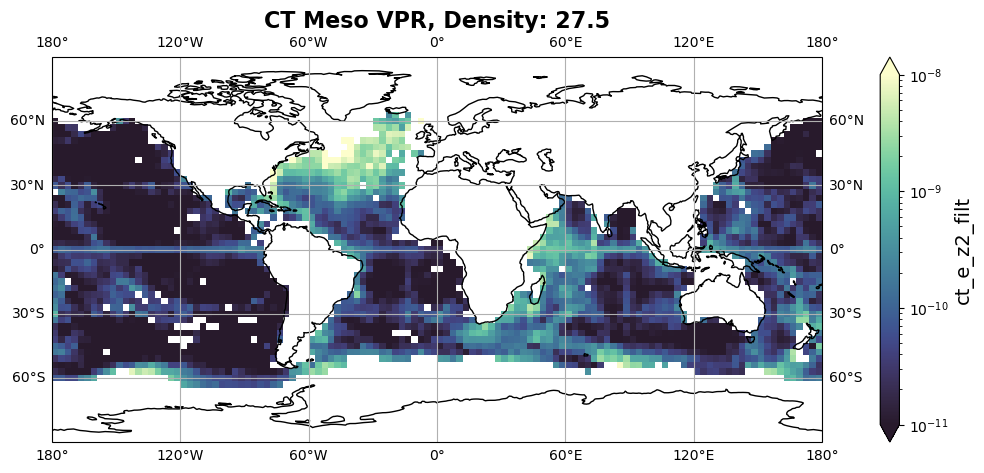

In [65]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ct_meso_VPR.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-11, vmax=1e-8))
ax.set_title('CT Meso VPR, Density: {}'.format(np.round(ct_meso_VPR.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/ct_meso_VPR_275.png', bbox_inches='tight')

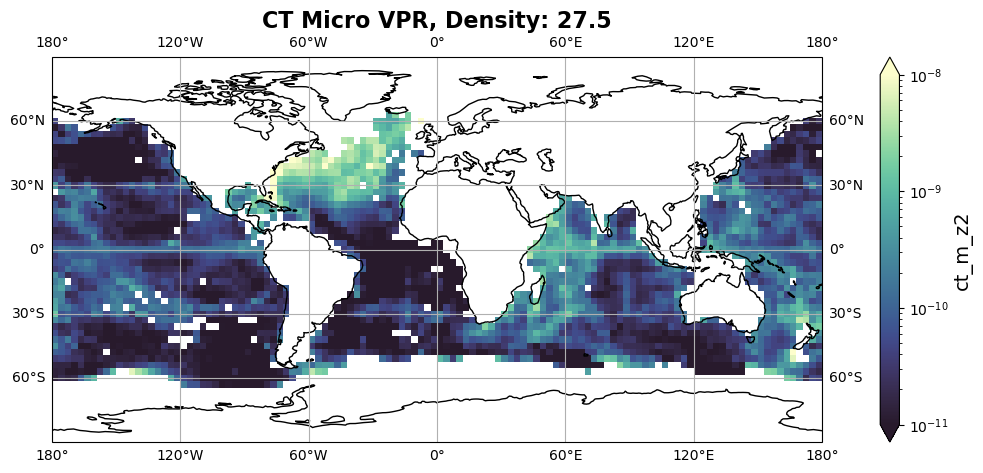

In [66]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ct_micro_VPR.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-1, vmax=1e-8))
ax.set_title('CT Micro VPR, Density: {}'.format(np.round(ct_micro_VPR.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/ct_micro_VPR_275.png', bbox_inches='tight')

CPU times: user 896 ms, sys: 10.3 ms, total: 907 ms
Wall time: 903 ms


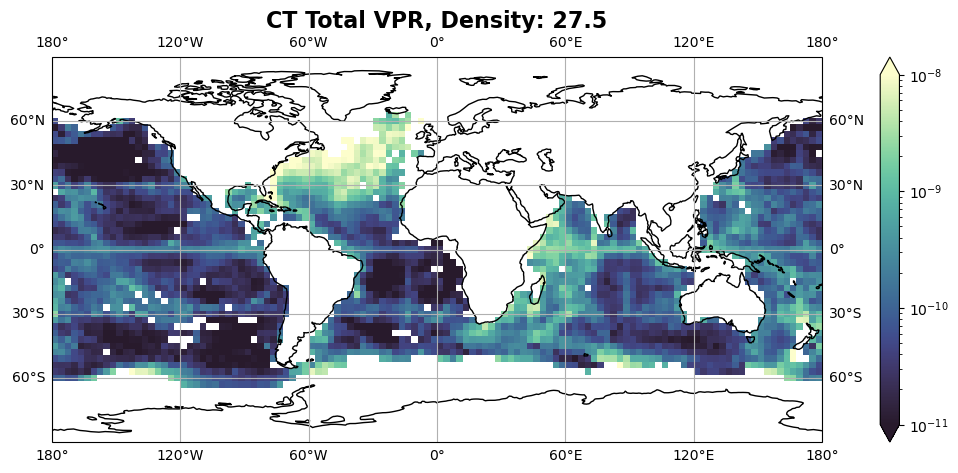

In [67]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ct_tot_VPR.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-11, vmax=1e-8))
ax.set_title('CT Total VPR, Density: {}'.format(np.round(ct_tot_VPR.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/ct_tot_VPR_275.png', bbox_inches='tight')

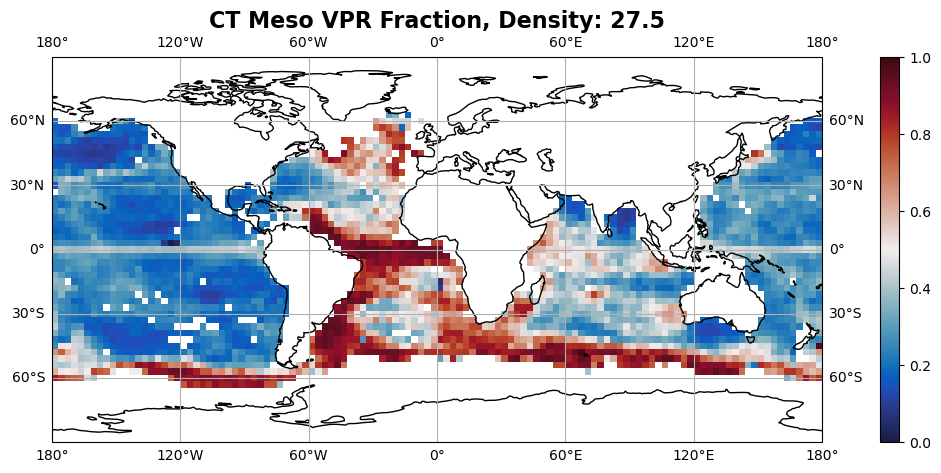

In [69]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ct2_frac_VPR.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=0, vmax=1)
ax.set_title('CT Meso VPR Fraction, Density: {}'.format(np.round(ct2_frac_VPR.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/ct2_frac_VPR_275.png', bbox_inches='tight')

## Plots: SA

In [57]:
sa_meso_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_meso_VPR.nc')
sa_micro_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_micro_VPR.nc')
sa_tot_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_tot.nc')
sa2_frac_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa2_frac.nc')

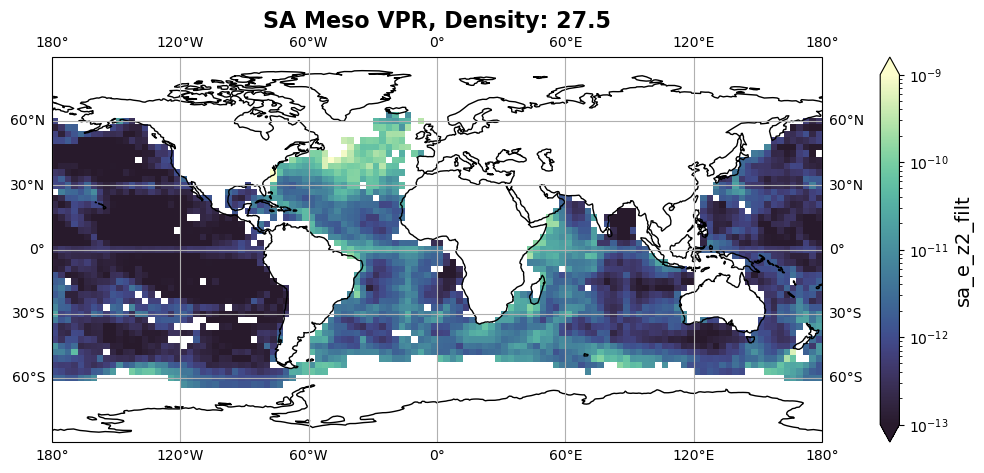

In [72]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
sa_meso_VPR.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-13, vmax=1e-9))
ax.set_title('SA Meso VPR, Density: {}'.format(np.round(sa_meso_VPR.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/sa_meso_VPR_275.png', bbox_inches='tight')

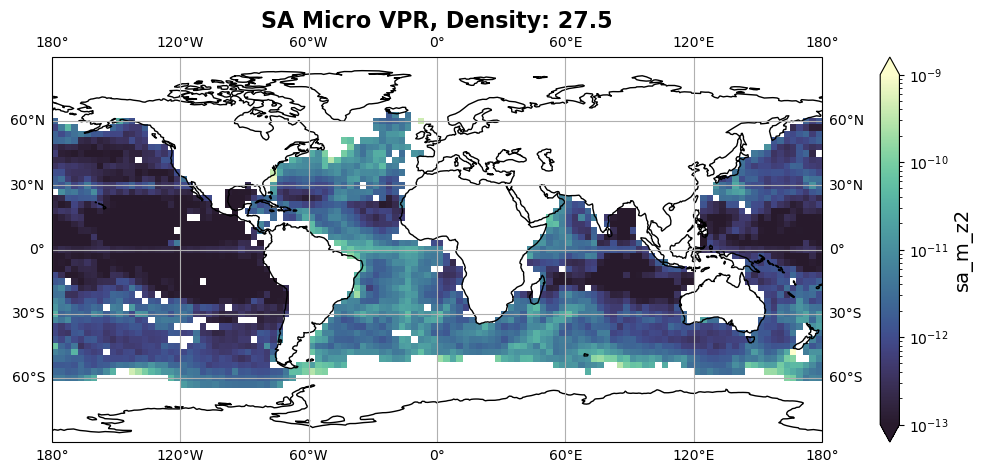

In [73]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
sa_micro_VPR.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-13, vmax=1e-9))
ax.set_title('SA Micro VPR, Density: {}'.format(np.round(sa_micro_VPR.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/sa_micro_VPR_275.png', bbox_inches='tight')

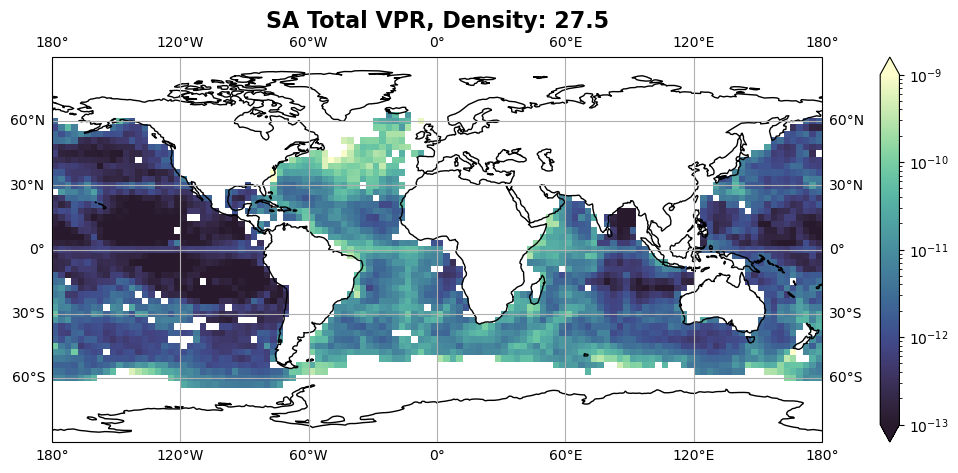

In [75]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
sa_tot_VPR.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-13, vmax=1e-9))
ax.set_title('SA Total VPR, Density: {}'.format(np.round(sa_tot_VPR.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/sa_tot_VPR_275.png', bbox_inches='tight')

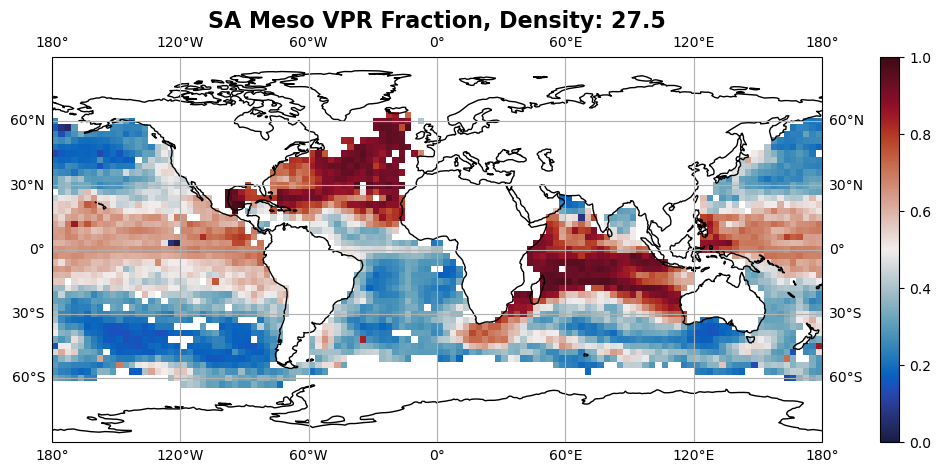

In [76]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
sa2_frac_VPR.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=0, vmax=1)
ax.set_title('SA Meso VPR Fraction, Density: {}'.format(np.round(ct2_frac_VPR.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/sa2_frac_VPR_275.png', bbox_inches='tight')